In [0]:
%pip install xgboost

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from xgboost import XGBClassifier

In [0]:
# Load the Cleaned and Feature-Engineered Dataset
tesla_featured = spark.table("tesla_stock_features").toPandas()  

In [0]:
# Defining the target variables
tesla_featured.dropna(inplace=True)
X = tesla_featured.drop(columns=['Target', 'Date'])
y = tesla_featured['Target']

In [0]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [0]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



✨ Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.19      0.28       340
           1       0.52      0.80      0.63       365

    accuracy                           0.51       705
   macro avg       0.49      0.50      0.45       705
weighted avg       0.49      0.51      0.46       705



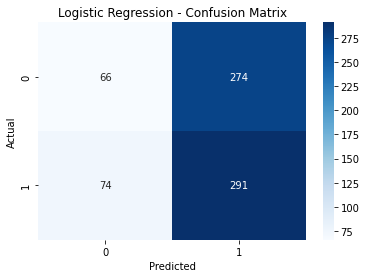



✨ Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.44      0.45       340
           1       0.50      0.52      0.51       365

    accuracy                           0.48       705
   macro avg       0.48      0.48      0.48       705
weighted avg       0.48      0.48      0.48       705



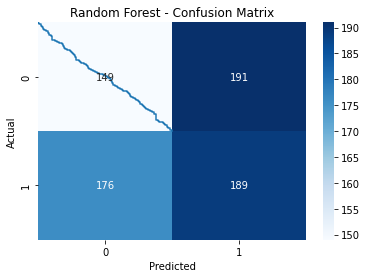

/local_disk0/.ephemeral_nfs/envs/pythonEnv-d6ea1f7b-9703-4030-902c-7c4e2b5cd54f/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:32:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




✨ XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.46      0.46       340
           1       0.50      0.50      0.50       365

    accuracy                           0.48       705
   macro avg       0.48      0.48      0.48       705
weighted avg       0.48      0.48      0.48       705



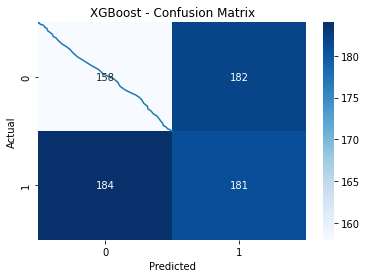

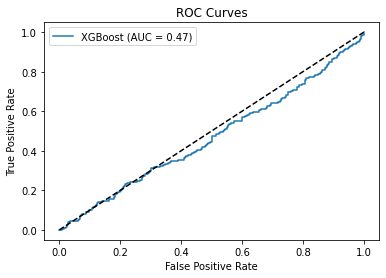

In [0]:
# Initialize and Train Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    results[name] = {'Accuracy': acc, 'ROC AUC': roc}

    print(f"\n\n\u2728 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


In [0]:
# Compare Results
results_df = pd.DataFrame(results).T.sort_values(by='ROC AUC', ascending=False)
print("Model Performance Comparison:")
display(results_df)

Model Performance Comparison:


Accuracy,ROC AUC
0.5063829787234042,0.5075584206285254
0.4794326241134752,0.48829170024174057
0.4808510638297872,0.469307010475423


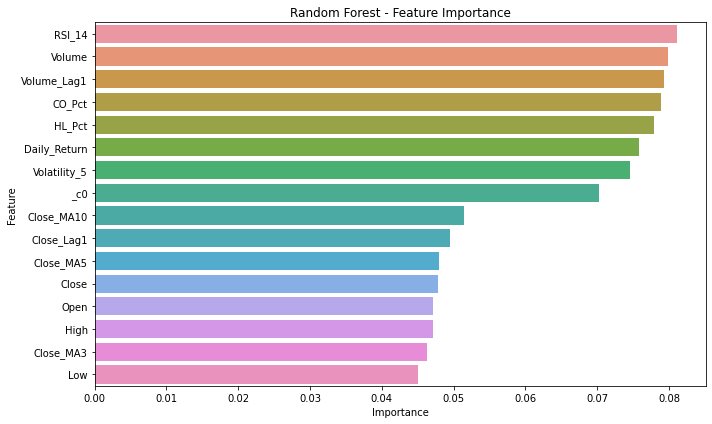

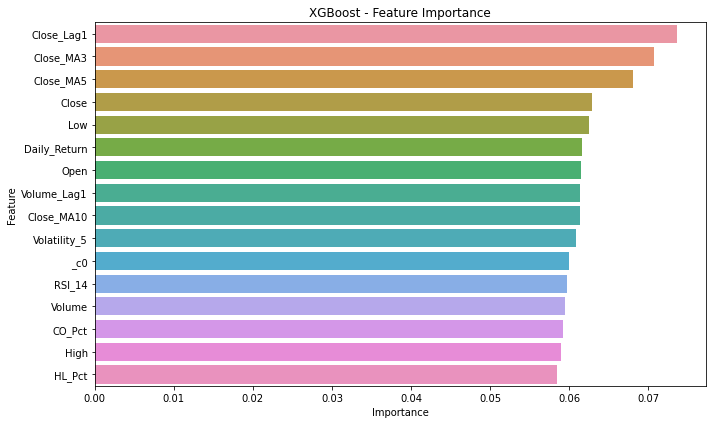

In [0]:
# Feature Importance (Random Forest and XGBoost)
for name in ['Random Forest', 'XGBoost']:
    model = models[name]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=features[indices])
    plt.title(f'{name} - Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [0]:
# Create a 'signal' column from predictions
best_model = models['XGBoost']  
predicted_proba = best_model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.5 
predicted_signal = np.where(predicted_proba > threshold, 1, 0)

# Append signals to a new DataFrame with dates
signals_df = X_test.copy()
signals_df['Actual'] = y_test.values
signals_df['Predicted_Prob'] = predicted_proba
signals_df['Signal'] = predicted_signal

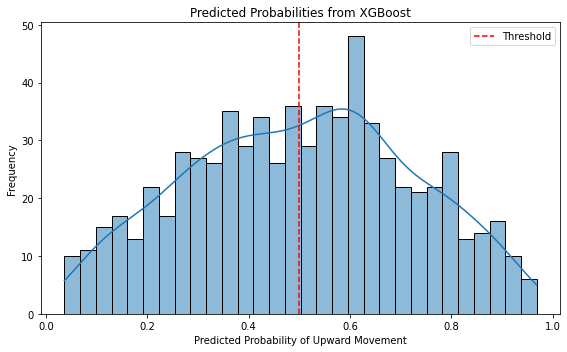

In [0]:
# Visualize the distribution of predicted probabilities
plt.figure(figsize=(8, 5))
sns.histplot(predicted_proba, bins=30, kde=True)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Predicted Probabilities from XGBoost')
plt.xlabel('Predicted Probability of Upward Movement')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [0]:
print(signals_df[['Predicted_Prob', 'Signal', 'Actual']].head(10))

      Predicted_Prob  Signal  Actual
744         0.116137       0       1
2454        0.236431       0       1
3258        0.790792       1       1
1135        0.254814       0       1
2921        0.618769       1       0
254         0.482457       0       0
3134        0.200013       0       1
1006        0.799150       1       0
1777        0.490424       0       1
3168        0.354984       0       1


In [0]:
tesla_signals = spark.createDataFrame(signals_df.reset_index())
tesla_signals.write.mode('overwrite').saveAsTable('tesla_model_signals')

In [0]:
%pip install mlflow

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


In [0]:
import mlflow
import mlflow.sklearn

In [0]:
with mlflow.start_run(run_name="tesla_xgboost_run"):
    mlflow.sklearn.log_model(best_model, "model")
    mlflow.log_params(best_model.get_params())

2025/05/27 22:32:48 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-6bfc6-79456-c94aa-8/tmpt2xby25_/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/05/27 22:32:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
